In [12]:
#!/usr/bin/env python3
import gym

import argparse
import shlex
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tensorboardX import SummaryWriter

from lib import dqn_model
import utils
import envs


from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
DEFAULT_ENV_NAME = "CarRacing-v2"
MEAN_REWARD_BOUND = 600

GAMMA = 0.99
BATCH_SIZE = 64
REPLAY_SIZE = 200 #10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 200
REPLAY_START_SIZE = 200 #10000

EPSILON_DECAY_LAST_FRAME = 2000 #150000
EPSILON_START = 0.9
EPSILON_FINAL = 0.01

OBSERVATION_SHAPE = (4,96,96)
ACTIONSPACE_SIZE = 5

In [19]:

parser = argparse.ArgumentParser()
parser.add_argument("--cuda", type=int, default=-1, help="Specify CUDA device number, default=-1 (CPU)")
parser.add_argument("--env", default=DEFAULT_ENV_NAME, help="Name of the environment, default=" + DEFAULT_ENV_NAME)
parser.add_argument("--save_dir", default="models", help="Directory in which to save the model weights, default=models")
parser.add_argument("--checkpoint", help="Path to a checkpoint file to resume training")
args = parser.parse_args(shlex.split(" --checkpoint=models/CarRacing-v2-best_tar.dat "))

In [20]:
def calc_loss(batch, net, tgt_net, device="cuda"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(np.array(states, dtype=np.float32, copy=False)).to(device)
    next_states_v = torch.tensor(np.array(next_states, dtype=np.float32, copy=False)).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(next_states_v).max(1)[0]
        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + \
                                   rewards_v
    return nn.MSELoss()(state_action_values,
                        expected_state_action_values)

In [21]:
device = torch.device("cuda:%d"%args.cuda if args.cuda>-1 else "cpu")
env = envs.GoodWrapper(gym.make('CarRacing-v2',continuous=False, render_mode="rgb_array"))
net = dqn_model.DQN(OBSERVATION_SHAPE, ACTIONSPACE_SIZE).to(device)
tgt_net = dqn_model.DQN(OBSERVATION_SHAPE, ACTIONSPACE_SIZE).to(device)
buffer = utils.ExperienceBuffer(REPLAY_SIZE)
agent = envs.Agent(env, buffer)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
epsilon = EPSILON_START
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

In [22]:
import logging,os
log_dir = 'log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
logging.basicConfig(filename='log/car-racing-ipynb.log', level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [23]:
if args.checkpoint:
    net.load_state_dict(torch.load(args.checkpoint))
    tgt_net.load_state_dict(net.state_dict())
    logger.info("Loaded checkpoint from %s" % args.checkpoint)
    print("Loaded checkpoint from %s" % args.checkpoint)

Loaded checkpoint from models/CarRacing-v2-best_tar.dat


In [24]:
# while(True):
agent._reset()

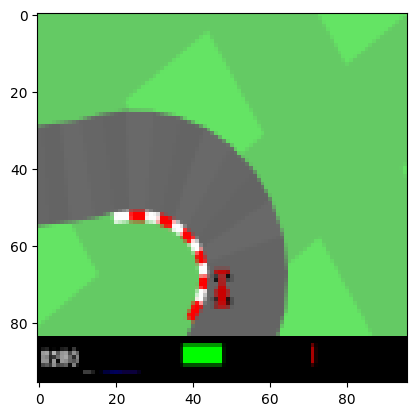

In [22]:
img = plt.imshow(env.debug_img) # only call this once
for _ in range(500):
    frame_idx += 1
#     epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    epsilon = 0.01
    reward = agent.play_step(net, epsilon, device=device)
    
    img.set_data(env.debug_img)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if reward is not None:
#         logger.info("GAME DONE frame_idx %s reward: %s epsilon: %s", frame_idx, reward, epsilon)
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print("%d: done %d games, reward %.3f, "
              "eps %.2f, speed %.2f f/s" % (
            frame_idx, len(total_rewards), m_reward, epsilon, speed
        ))
#         writer.add_scalar("epsilon", epsilon, frame_idx)
#         writer.add_scalar("speed", speed, frame_idx)
#         writer.add_scalar("reward_100", m_reward, frame_idx)
#         writer.add_scalar("reward", reward, frame_idx)
        if best_m_reward is None or best_m_reward < m_reward:
#             torch.save(net.state_dict(), args.env +
#                        "-best_%.0f.dat" % m_reward)
            pass
            if best_m_reward is not None:
                print("Best reward updated %.3f -> %.3f" % (
                    best_m_reward, m_reward))
            best_m_reward = m_reward
        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()
# writer.close()